In [1]:
#Dawit Belayneh; JC Model for cavity rydbergs 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# 2-level states 

spin_up = basis(2,0) 
spin_down = sigmax() * spin_up 

# Note: spin_down = (1, 0); spin_up = (0, 1)
# doesn't matter for our purposes 

In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

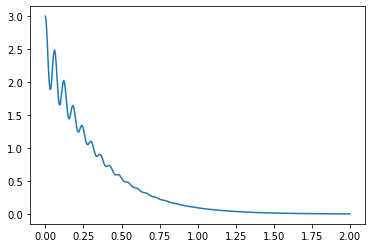

In [2]:
# JC stuff 
# example: decay and exchange of 'photon_init' photons between cavity and atom
# some parameters 

#coupling strength 
g = 30
# decay param
kappa = 1.4
gamma = 6
cav_exc_max = 5
#
prb = 0.2 # probing frequency 
phot_init = 3 #num of photons in EM bath at start 

# Hilbert state of cavity and atom 
# and some init ground states 
cav0 = basis(cav_exc_max, n = phot_init)
qubit0 = sigmam() * basis(2,0) # ground state

# sigma plus and minus null when out of bound
# basis(2, 0) = up indices work as in cs 
#print(qubit0)

psi0 = tensor([cav0, qubit0]) # |n=2, spin_down>
# when tensoring states need []
#print(cav0) how does cav work?

#useful operatrs and Hamiltonian
Id = tensor(qeye(cav_exc_max), qeye(2)) # identity op
a = tensor(destroy(cav_exc_max), qeye(2)) # cavity annahilation

drive = (a.dag() + a) # drives cavity at needed frequency # drive is weird!
qubit_excitations = tensor(qeye(cav_exc_max), (sigmaz()+1)/2)
# counts qubit excitations
# used to count total photon energy including ones captured by atom

exchange = (tensor(create(cav_exc_max), sigmam())); # atom gives up photon
exchange = exchange + exchange.dag(); # full exchange
# exchange.dag() : atom absorbs photon
# the way exchange is defined ==> cavity and atom @ same frequency because 
# they can exchange.


#JC Hamiltonian
#g is the cavity atom coupling constant
H = prb*drive + g*exchange
# H does not count photon energy
# note: drive |n> = |n+1> + |n-1> i.e splits num state

# list of collapse operators [cavity decay, atomic decay]
# gamma controls atomic decay rate 
# kappa controls photonic decay rate 
c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]
# These operators define dissapation process
# They are ops that couple system to environment

#basic numbers and plots 
times = np.linspace(0.0, 2.0, 400)
result = mesolve(H, psi0, times, c, [a.dag()*a])

fig, ax = plt.subplots()
ax.plot(times, result.expect[0])
# result.expect[0] is a time-ordered list

# In closed JC system Cavity Photon Number 
# would oscillate between 2 and 1 via Rabi Oscillation
# ~ sine squared oscillation (ref. Tong, Applications of Quantum Mechanics).
# exp supression comes from dissapation.

/home/dawit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


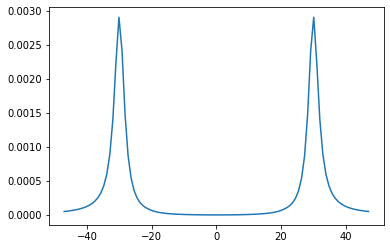

In [3]:
# Vaccum Rabi Splitting 
# assuming cav-atom resonance

# parameters 
g = 30
kappa = 1.4 
gamma = 6
prb = 0.2
npts = 101

###
nphot = np.empty(npts)
deltas = np.linspace(1.5*(-g-kappa), 1.5*(g+kappa), npts)

for i, delta in enumerate(deltas, start=0):
    #Hamiltonian 
    H = prb*drive + g*exchange + delta*(a.dag()*a + qubit_excitations) 
    # Now we add energy of photons in cavity and atoms
    # @ energy/frequency: delta.   
    
    # collapse ops [cavity_decay, atomic_decay]
    c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
         np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]
    
    rho_ss = steadystate(H, c , method='direct')
    # steadystate density matrix
    nphot[i] = np.trace(a.dag()*a*rho_ss)
    # expectation of num operator for each delta value 
    
    
fig = plt.figure()
plt.plot(deltas, nphot)
# x-axis: deltas 
# y-axis: nphot

**Where Does the Vaccum Rabi Splitting come from?**

*VRS is an effect that becomes prominent **when the coupling between cavity and atom is dominant**. Then, the eigenstates of our system ($H_{JC}$) are no longer the cavity egenstate and atom eigenstates. They are linear supperpositions of the form:* 

$$|n, down\rangle \pm |n-1, up\rangle$$ 

*up to a constant **when cavity and atom are at resonance**. (what happens when they're not?)*

The code above searches for the energies of the g(exchange) term as they are the steadystate solutions. We see a peak in photon number at those energy values (when delta coincides with the energies). This is because the above linear combinations become eigenstates of the delta(a.dag()a + qubit_excitation) term when the following are satisfied: 

* n is large enough that n-1 is roughly n, and
* delta coincides with the energies of g(exchange) operator 

We also need that $prb \ne 0$ to induce some photons? Yes! 

**The point of this plot is to show that at high g values eigenstates are no longer 
cavity or atom eigen states but the linear combinations shown above.**

In [4]:
# compute the prob of state up as a function of time given
# initial state of cavity-atom is coherent state and down

# should observe Rabi -> collapse -> revival -> high non-linearity
# at times roughly T_rabi, T_collapse, T_revival
# count difference in time in units of rabi cycles 

# To do this figure out how to find projection of psi_t on to 
# sum_{n} |n, up> (QuTip thing)

/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'g=150 | $\\kappa$=1.4 | $\\Gamma$=3 | PrbPwr=0.1')

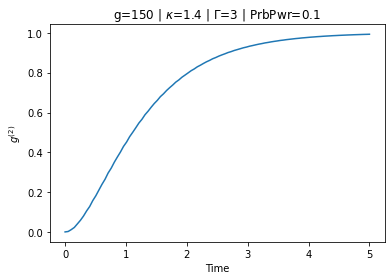

In [5]:
# g2 stuff 
# g2: "probe" on VRS peak, look for g2 suppression

max_time = 5.0
time_steps = 100
# probe on VRS peak 
g = 150 # high non-linearity ~ +- g
kappa = 1.4
gamma = 3
prb= 0.1
npts = 101 
delta = g # i.e around peak (see prev cells)

# array of times for calculating evolution after a photon was detected
times = np.linspace(0.0, max_time, time_steps)

# Hamiltonian
H = prb*drive + g*exchange + delta*(a.dag()*a + qubit_excitations)
# Note: g = delta here 

# list of collapse operators [cavity decay, atomic decay]
c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
     np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]

# prepare options for mesolver to not tidy up small values
# we don't want to loose small numbers 
options = Options(tidy=False)

# find steadystate 
rho_ss = steadystate(H, c, method='direct')

#calculate 
rho_m1 = a * rho_ss * a.dag() # remove one photon
norm = np.trace(rho_m1) # normalization factor 
rho_m1 = a * (rho_ss / norm) * a.dag() # renormalization
rho_m1_t = mesolve(H, rho_m1, times, c , [a.dag()*a], options=options)
# time evolve renormalized state 
# and extract <N>, num op

#build g2
num = rho_m1_t.expect[0] * norm
den = np.power(np.trace(a.dag()*a*rho_ss), 2)

g2 = num/den

# matplotlib
fig=plt.figure()
plt.plot(times, g2)   
plt.xlabel('Time')
plt.ylabel('$g^{(2)}$')
plt.title('g='+str(g) + ' | $\kappa$=' + str(kappa) + ' | $\Gamma$=' + str(gamma) + ' | PrbPwr=' + str(prb))

**$g{(2)}$ between steady-state solution of JC and steady-state with one less photon @ cavity-atom resonance**

*If the steady state solution was a coherent state, we would have see $g^{(2)}(t) = 1$ as $a \rho_{ss} a^{\dagger} = \rho_{ss}$ for a coherent state.*

*Since it takes some finite amount of time for the $g^{(2)}$ to be 1 we see that $\rho_{ss}$ is not a simple coherent state.*


*The dependence of $g^{(2)}(t)$ on the coupling parameter is intersting:*
* small g sees the curve fliping and oscillating wildly on its way to 1
* medium g sees the curve with a log trend up to 1 with small oscillating features along the curve **Q: why is g(0) = 0?** 
* high g see the oscillations die out (no new features appear after some high enough g value)

**Q: How good is $g^{(2)}(t)$ at indentifyig if $\rho_{ss}$ is a coherent state?**

**Example: $H = N = a^\dagger a$ with $|\psi_i\rangle = |n\rangle$**

Since $[H, N] = 0, N(t) = N(0) = N.$ Then, $g^{(2)}(t)$ is given by: 

$$g^{(2)}(t) = \frac{Tr(N \rho_{n-1})}{Tr(N \rho_n)^2} = 1 - \frac{1}{n}.$$

For $n = 1, g = 0$ but for a coherent state $g = 1$. So, $$0 = g^{(2)}_{n = 1}(t) \le g^{(2)}(t) \le g^{(2)}_{coh}(t) = 1$$

**1 is an upper bound of $g^2(t)$ only for this Hamiltonian.**

/home/dawit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0, 0.5, '$g^{(2)}$')

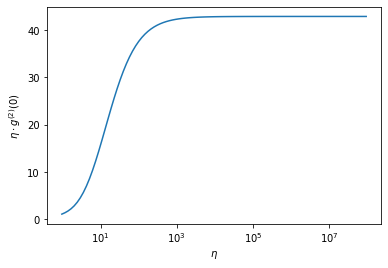

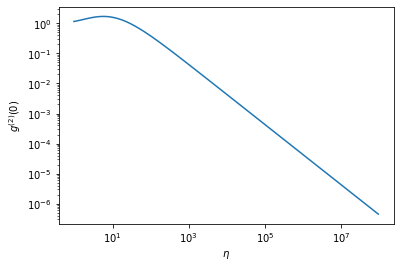

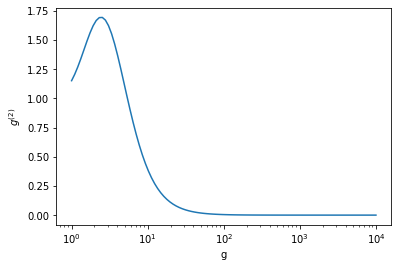

In [6]:
# what is g2(0) as a function of the co-operativity?

# what does co-operativity measure? 

# g2: probe on VRS peak, look for g2 supression 

max_time = 5.0 

gexp = np.linspace(0.0, 4.0, 100)
g = 10 ** gexp
kappa = 1.4
gamma = 3
prb = 0.2
delta = g # on VRS peak 

# array of times for calculating evolution after removing
# a photon 
times = np.linspace(0.0, max_time, time_steps)

g2 = 0*g # list of zeros as of now 
for i, thisg in enumerate(g):
    H = prb*drive + thisg*exchange + delta[i]*(a.dag()*a + qubit_excitations)
    # list of collapse operators [cavity decay, atomic decay]
    c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
         np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]
    
    # calculate steady state 
    rho_ss = steadystate(H, c, method='direct')
    # calculate g2(0)
    rho_m1 = a * rho_ss * a.dag()
    norm = np.trace(rho_m1)
    rho_m1 = a * (rho_ss / norm) * a.dag()
    num = np.trace(a.dag()*a*(rho_m1 * norm))
    den = np.power(np.trace(a.dag()*a*rho_ss), 2)
    g2[i] = num/den 
    
# we just computed the g2 values for a various values of g 
# @ VRS peak, that is @ deta = g.

fig10 = plt.figure()
eta = 4*g**2/kappa/gamma # what is eta (list of values)?
plt.semilogx(eta, g2*eta) # semilogx : x-axis is log val 
plt.ylabel('$\eta \cdot g^{(2)}(0)$')
plt.xlabel('$\eta$')

fig20 = plt.figure()
eta = 4*g**2/kappa/gamma
plt.loglog(eta, g2) # loglog : x,y-axis log vals 
plt.ylabel('$g^{(2)}(0)$')
plt.xlabel('$\eta$')

fig=plt.figure()
plt.semilogx(g, g2)   
plt.xlabel('g')
plt.ylabel('$g^{(2)}$')

(0.9999965828995363+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'g=0 | $\\kappa$=1.4 | $\\Gamma$=3 | PrbPwr=0.1')

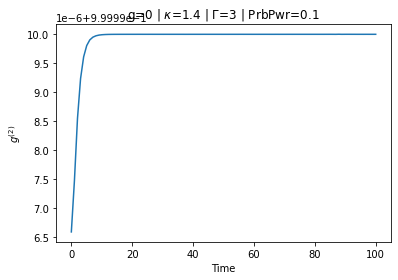

In [7]:
# g2 for drive only hamiltonian 
# Expect: g2(0) = 1 should be exactly one
# but that doesn't make sense as a.dag() term 
# will not have coherent states as eigen-states

max_time = 100
time_steps = 100
g = 0
kappa = 1.4
gamma = 3
prb = 0.1
npts = 101
delta = g 

times = np.linspace(0.0, max_time, time_steps)

# Hamiltonian 
H = prb*drive 

# list of collapse operators [cavity decay, atomic decay]
c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
     np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]

# prepare options for mesolver to not tidy up small values
# we don't want to loose small numbers 
options = Options(tidy=False)

# steady state 
rho_ss = steadystate(H, c, method='direct')

# calculate time evolition after removing a photon
rho_m1 = a * rho_ss * a.dag() # remove one photon from SS
norm = np.trace(rho_m1) # normalization factor 
rho_m1 = a * (rho_ss / norm) * a.dag() # renormalize SS
rho_m1_t = mesolve(H, rho_m1, times, c, [a.dag()*a], options=options)
# time evolve renormalized state 
# and extract <N> , num op

# build g2
num = rho_m1_t.expect[0] * norm  
den = np.power(np.trace(a.dag()*a*rho_ss), 2)


g2 = num/den 
print(g2[0])

# matplotlib
fig=plt.figure()
plt.plot(times, g2)   
plt.xlabel('Time')
plt.ylabel('$g^{(2)}$')
plt.title('g='+str(g) + ' | $\kappa$=' + str(kappa) + ' | $\Gamma$=' + str(gamma) + ' | PrbPwr=' + str(prb))

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.79798674e-01+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+1.39971238e-01j
   0.00000000e+00+0.00000000e+00j -1.41392253e-02+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00-1.16614338e-03j
   0.00000000e+00+0.00000000e+00j  8.28731333e-05+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000

/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'g=0 | $\\kappa$=1.4 | $\\Gamma$=3 | PrbPwr=0.1')

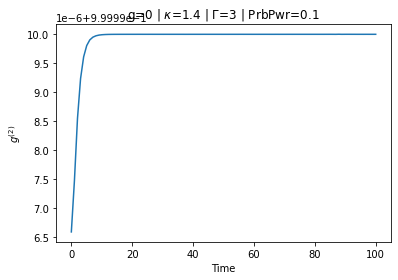

In [9]:
# Just a test that coherence_function_g2(...) works
#
# g2 for drive only hamiltonian 
# Expect: g2(0) = 1 should be exactly one
# but that doesn't make sense as a.dag() term 
# will not have coherent states as eigen-states
#

max_time = 100
time_steps = 100
g = 0
kappa = 1.4
gamma = 3
prb = 0.1
npts = 101
delta = g 

times = np.linspace(0.0, max_time, time_steps)

# Hamiltonian 
H = prb*drive 

# list of collapse operators [cavity decay, atomic decay]
c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
     np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]

# prepare options for mesolver to not tidy up small values
# we don't want to loose small numbers 
options = Options(tidy=False)

# steady state 
rho_ss = steadystate(H, c, method='direct')
print(rho_ss)

g2_t = coherence_function_g2(H, rho_ss, times, c, a)[0] # return normalized g2
print(g2_t[0])

# matplotlib
fig=plt.figure()
plt.plot(times, g2)   
plt.xlabel('Time')
plt.ylabel('$g^{(2)}$')
plt.title('g='+str(g) + ' | $\kappa$=' + str(kappa) + ' | $\Gamma$=' + str(gamma) + ' | PrbPwr=' + str(prb))